# Определение перспективного тарифа для телеком компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Она предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.


Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 


Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение и подготовка данных

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

%matplotlib inline

Первым шагом рассмотрим общую информацию о данных в таблицах. Прочитаем её из .csv-файлов и выведем общую информацию.

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Сначала - общие данные о **пользователях**.

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Проверим на пропуски.

In [5]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Оставляем пропуски незаполненными.

Приведём столбцы с датами к формату "дата-время".

In [6]:
users['churn_date'] = pd.to_datetime(users.churn_date)
users['reg_date'] = pd.to_datetime(users.reg_date)

In [7]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Выведем общую информацию по таблице данных **о звонках**.

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Рассмотрим базовые статистики по таблице.

In [11]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В среднем, звонки не превышают семь минут. Максимальное время - 38 минут. Есть и звонки с нулевой продолжительностью. Как говорится в сопроводительной информации от «Мегалайн» - это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Построим графики.

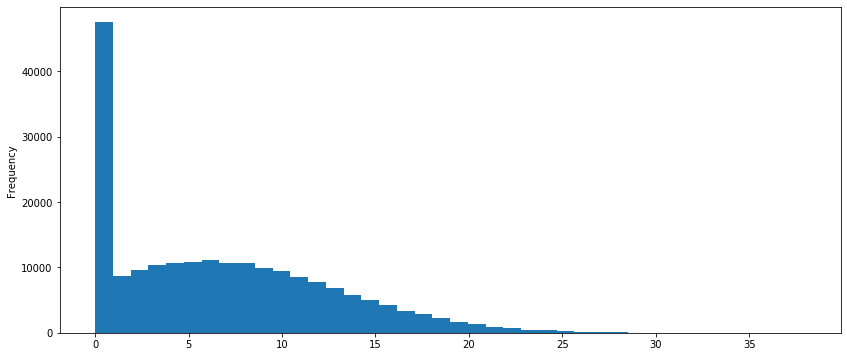

In [12]:
plt.figure(figsize=(14, 6))
calls.duration.plot(kind='hist', bins=40)
plt.show()

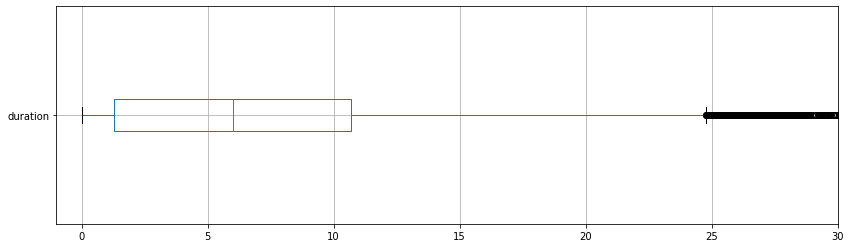

In [13]:
plt.figure(figsize=(14, 4))
calls.duration.plot(kind='box', grid=True, vert=False)
plt.xlim(-1, 30)
plt.show()

Судя по графикам, датасет скошен вправо. Присутствует большое количество околонулевых (от одной секунды), пропущенных звонков и выбросов. Но на медианное значение это практически не влияет.

Основная масса абонентов разговаривает, примерно, от двух до десяти минут.

Достаточно много людей проводит в звонке до 20 минут и более. Однако, в районе 25 минут начинаются экстремальные значения - выбросы. Людей, говорящих так долго, не много.

Проверим на пропуски.

In [14]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Приведём столбец с датой к формату "дата-время".

In [15]:
calls['call_date'] = pd.to_datetime(calls.call_date)

duration — длительность звонка в минутах. «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Проверим, сколько "секундных" звонков в нашей таблице.

In [16]:
calls.loc[calls.duration == 0.01].count()

id           101
call_date    101
duration     101
user_id      101
dtype: int64

Сто звонков. А ведь есть звонки по две, пять, двадцать секунд. Округлим их в бОльшую сторону, согласно правилам «Мегалайн».

Импортируем из библиотеки math  функцию для округления в нужную сторону.

In [17]:
from math import ceil

Округляем и смотрим на результат.

In [18]:
#calls['duration'] = calls['duration'].apply(ceil)
calls['duration'] = np.ceil(calls['duration'])

In [19]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Как видим, округление в бОльшую сторону произошло.

На очереди таблица с **сообщениями**.

In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [21]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Смотрим пропуски.

In [22]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

Приводим столбец к "дата-время".

In [23]:
messages['message_date'] = pd.to_datetime(messages.message_date)

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Таблица с информацией об **интернет-сессиях**.

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [26]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


В таблице видим столбец 'Unnamed: 0'. На первый взгляд, его значения совпадают с индексом таблицы. Проверим это.

In [27]:
internet['Unnamed: 0'].sort_values()

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

Так и есть. Очевидное совпадение. Скорее всего, при выгрузке данных, значения индекса попали в отдельный столбец. Можем смело его удалить.

In [28]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

Приводим нужный столбец к "дата-время".

In [29]:
internet['session_date'] = pd.to_datetime(internet.session_date)

In [30]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Базовые статистики по таблице.

In [31]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


В среднем, пользователи тратят 370 мегабайт трафика за одну сессию. Кто-то "сжигает" более полутора гигабайт за один присест, но есть, как минимум, одна сессия с нулевым значением. 

Узнаем, сколько всего нулевых сессий.

In [32]:
internet.loc[internet.mb_used == 0, 'mb_used'].count()

19598

Порядка двадцати тысяч строк, из почти ста пятидесяти тысяч. Это могут быть как сбои подключения, так и прерванные пользователем сессии, не превышающие один мегабайт. Либо, как вариант, ошибки при выгрузке данных по пользователю. Оставим нули как есть. Они не должны сильно повлиять на наши исследования.

Построим графики.

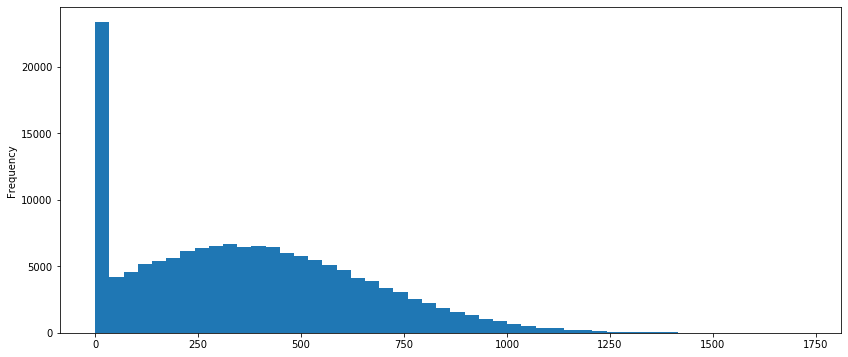

In [33]:
plt.figure(figsize=(14, 6))
internet.mb_used.plot(kind='hist', bins=50)
plt.show()

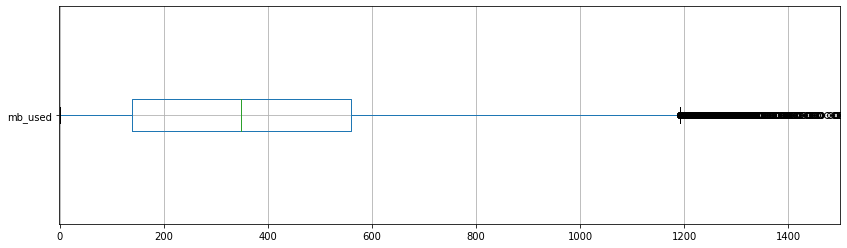

In [34]:
plt.figure(figsize=(14, 4))
internet.mb_used.plot(kind='box', grid=True, vert=False)
plt.xlim(-1, 1500)
plt.show()

График скошен вправо и напоминает распределение "звонков". 

Как и в "звонках", много околонулевых значений и достаточное количество выбросов. В основном, трафик за сессию не превышает 600 мегабайт. Выбросы начинаются посе 1200 мегабайт.

И таблица с **информацией по тарифам**.

In [35]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [36]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Тут ничего необычного.

## Подготовка сводной таблицы

Для удобства подсчётов и анализа данных, сведём все имеющиеся таблицы в одну.

Начнём с данных по **звонкам пользователей**. Объединим таблицы с пользователями и звонками, по столбцу 'user_id'.

In [37]:
data_calls = pd.merge(users, calls, on='user_id', how='left')
data_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0


Добавим в сводную таблицу столбец с названием месяца, основываясь на дате звонка.

In [38]:
data_calls['month'] = data_calls.call_date.dt.month_name()

In [39]:
data_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,July
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,August
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,June
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,September
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,December


Сгруппируем таблицу и посчитаем, **сколько звонков** было сделано пользователями **по месяцам**.

In [40]:
calls_by_month = data_calls.groupby(['user_id', 'city', 'month', 'tariff'], as_index=False).agg({'call_date':'count'})
calls_by_month.columns = ['user_id', 'city', 'month', 'tariff', 'calls']
calls_by_month.head()

,user_id,city,month,tariff,calls
0,1000,Краснодар,August,ultra,52
1,1000,Краснодар,December,ultra,46
2,1000,Краснодар,July,ultra,47
3,1000,Краснодар,June,ultra,43
4,1000,Краснодар,May,ultra,22


Сгруппируем таблицу и посчитаем, **сколько минут разговоров**, было потрачено пользователями **по месяцам**.

In [41]:
minutes_by_month = data_calls.groupby(['user_id', 'city', 'month', 'tariff'], as_index=False).agg({'duration':'sum'})
minutes_by_month.columns = ['user_id', 'city', 'month', 'tariff', 'minutes']
minutes_by_month.minutes = round(minutes_by_month.minutes)
minutes_by_month.head()

,user_id,city,month,tariff,minutes
0,1000,Краснодар,August,ultra,408.0
1,1000,Краснодар,December,ultra,333.0
2,1000,Краснодар,July,ultra,340.0
3,1000,Краснодар,June,ultra,172.0
4,1000,Краснодар,May,ultra,159.0


По образцу со звонками, сделаем таблицу с **сообщениями пользователей**.

In [42]:
data_messages = pd.merge(users, messages, on='user_id', how='left')
data_messages['month'] = data_messages.message_date.dt.month_name()
data_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,June
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,October
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,August
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,June
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,December


Сгруппируем по **количеству сообщений в месяц**. 

In [43]:
messages_by_month = data_messages.groupby(['user_id', 'city', 'month', 'tariff'], as_index=False).agg({'message_date':'count'})
messages_by_month.columns = ['user_id', 'city', 'month', 'tariff', 'messages']
messages_by_month.head()

,user_id,city,month,tariff,messages
0,1000,Краснодар,August,ultra,81
1,1000,Краснодар,December,ultra,70
2,1000,Краснодар,July,ultra,75
3,1000,Краснодар,June,ultra,60
4,1000,Краснодар,May,ultra,22


Сводная таблица по **интернет-трафику**.

In [44]:
data_traffic = pd.merge(users, internet, on='user_id', how='left')
data_traffic['month'] = data_traffic.session_date.dt.month_name()
data_traffic.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,112.95,2018-11-25,November
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1052.81,2018-09-07,September
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1197.26,2018-06-25,June
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,550.27,2018-08-22,August
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,302.56,2018-09-24,September


Как мы знаем, по тарифам «Мегалайн», для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Сделаем сводную таблицу **трафика по месяцам** и переведём мегабайты в гигабайты.

In [45]:
monthly_traffic = data_traffic.groupby(['user_id', 'city', 'month', 'tariff'], as_index=False).agg({'mb_used':'sum'})
monthly_traffic.columns = ['user_id', 'city', 'month', 'tariff', 'gigabytes']
monthly_traffic.gigabytes = round(monthly_traffic.gigabytes / 1024, 3)
monthly_traffic.head()

,user_id,city,month,tariff,gigabytes
0,1000,Краснодар,August,ultra,13.726
1,1000,Краснодар,December,ultra,9.588
2,1000,Краснодар,July,ultra,13.675
3,1000,Краснодар,June,ultra,22.689
4,1000,Краснодар,May,ultra,2.201


Необходимо округление в бОльшую сторону. Воспользуемся знакомой нам функцией ceil.

In [46]:
monthly_traffic['gigabytes'] = monthly_traffic['gigabytes'].apply(ceil)
monthly_traffic.head()

,user_id,city,month,tariff,gigabytes
0,1000,Краснодар,August,ultra,14
1,1000,Краснодар,December,ultra,10
2,1000,Краснодар,July,ultra,14
3,1000,Краснодар,June,ultra,23
4,1000,Краснодар,May,ultra,3


На очереди - объединение данных в одну **общую таблицу**.

In [47]:
data_1 = pd.merge(calls_by_month, minutes_by_month, how='outer')
data_2 = pd.merge(messages_by_month, monthly_traffic, how='outer')
users_data = pd.merge(data_1, data_2, how='outer')
users_data

,user_id,city,month,tariff,calls,minutes,messages,gigabytes
0,1000,Краснодар,August,ultra,52.0,408.0,81.0,14.0
1,1000,Краснодар,December,ultra,46.0,333.0,70.0,10.0
2,1000,Краснодар,July,ultra,47.0,340.0,75.0,14.0
3,1000,Краснодар,June,ultra,43.0,172.0,60.0,23.0
4,1000,Краснодар,May,ultra,22.0,159.0,22.0,3.0
...,...,...,...,...,...,...,...,...
3209,1489,Санкт-Петербург,December,smart,NaN,NaN,35.0,17.0
3210,1489,Санкт-Петербург,November,smart,NaN,NaN,20.0,18.0
3211,1489,Санкт-Петербург,October,smart,NaN,NaN,21.0,20.0
3212,1489,Санкт-Петербург,September,smart,NaN,NaN,32.0,17.0


Добавляем к нашей сводной таблице данные по тарифам. Для удобства, переименуем столбец с названиями.

In [48]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [49]:
users_data = pd.merge(users_data, tariffs)
users_data

,user_id,city,month,tariff,calls,minutes,messages,gigabytes,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,August,ultra,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,December,ultra,46.0,333.0,70.0,10.0,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,July,ultra,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,June,ultra,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,May,ultra,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,Санкт-Петербург,August,smart,NaN,NaN,17.0,11.0,50,15360,500,550,200,3,3
3210,1489,Санкт-Петербург,December,smart,NaN,NaN,35.0,17.0,50,15360,500,550,200,3,3
3211,1489,Санкт-Петербург,November,smart,NaN,NaN,20.0,18.0,50,15360,500,550,200,3,3
3212,1489,Санкт-Петербург,October,smart,NaN,NaN,21.0,20.0,50,15360,500,550,200,3,3


Проверим таблицу на пропуски.

In [50]:
users_data.isna().sum()

user_id                    0
city                       0
month                      0
tariff                     0
calls                     40
minutes                   40
messages                 497
gigabytes                 11
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

Очевидно, что кто-то из пользователей мог **не звонить, не писать сообщения, или не пользоваться интернетом**. Заполним пропуски нулём.

In [51]:
users_data.fillna(0, inplace=True)

Посчитаем **помесячную выручку с каждого пользователя**. Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика. Остаток умножим на значение из тарифного плана. Прибавим абонентскую плату, соответствующую тарифу.

In [52]:
# Отрицательные значения приравниваем к 0:
users_data['calls_income'] = (users_data['minutes'] - users_data['minutes_included']) *  users_data['rub_per_minute']
users_data.loc[users_data.calls_income <= 0, 'calls_income'] = 0

users_data['msg_income'] = (users_data['messages'] - users_data['messages_included']) *  users_data['rub_per_message']
users_data.loc[users_data.msg_income <= 0, 'msg_income'] = 0

users_data['int_income'] = (users_data['gigabytes'] - (users_data['mb_per_month_included'] / 1024)) *  users_data['rub_per_gb']
users_data.loc[users_data.int_income <= 0, 'int_income'] = 0

users_data['total_income'] = users_data['calls_income'] + users_data['msg_income'] + users_data['int_income'] + users_data['rub_monthly_fee']
users_data

,user_id,city,month,tariff,calls,minutes,messages,gigabytes,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_income,msg_income,int_income,total_income
0,1000,Краснодар,August,ultra,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,Краснодар,December,ultra,46.0,333.0,70.0,10.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,Краснодар,July,ultra,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,Краснодар,June,ultra,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,Краснодар,May,ultra,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,Санкт-Петербург,August,smart,0.0,0.0,17.0,11.0,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
3210,1489,Санкт-Петербург,December,smart,0.0,0.0,35.0,17.0,50,15360,500,550,200,3,3,0.0,0.0,400.0,950.0
3211,1489,Санкт-Петербург,November,smart,0.0,0.0,20.0,18.0,50,15360,500,550,200,3,3,0.0,0.0,600.0,1150.0
3212,1489,Санкт-Петербург,October,smart,0.0,0.0,21.0,20.0,50,15360,500,550,200,3,3,0.0,0.0,1000.0,1550.0


## Анализ данных

**Посчитаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц**.

Начнём с **тарифа "Ультра"**.

Посчитаем, сколько в среднем, пользователи тратят минут, сообщений и интернет-трафика в месяц.

In [53]:
tariff_ultra_data = users_data.loc[users_data['tariff'] == 'ultra']

round(tariff_ultra_data.groupby('month', as_index = False).\
agg({'minutes':'mean', 'messages':'mean', 'gigabytes':'mean'}))

,month,minutes,messages,gigabytes
0,April,458.0,32.0,17.0
1,August,511.0,48.0,20.0
2,December,593.0,61.0,22.0
3,February,297.0,22.0,12.0
4,January,428.0,34.0,13.0
5,July,546.0,50.0,21.0
6,June,480.0,42.0,19.0
7,March,490.0,32.0,18.0
8,May,510.0,38.0,19.0
9,November,541.0,56.0,20.0


Рассмотрим общие статистики по тарифу. 

In [54]:
tariff_ultra_data[['minutes', 'messages', 'gigabytes']].describe()

,minutes,messages,gigabytes
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416
std,317.606098,47.804457,9.853511
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,12.000000
50%,518.000000,38.000000,19.000000
75%,752.000000,79.000000,27.000000
max,1673.000000,224.000000,49.000000


В среднем, пользователи тарифа "Ультра", разговаривали порядка 530 минут, отослали около 50 сообщений и потратили 20 гигабайт трафика. Любопытно, что эти данные пересекаются с тарифом "Смарт", где включены 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.


Кто-то вообще не пользовался звонками и сообщениями, а кто-то наговорил 1673 минуты и отправил 224 послания. Если это один человек, то он очень деятельный :)


Медиана и среднее достаточно близко, значит выбросов в данных не так много. 

Рассмотрим **тариф "Смарт"**.

Посчитаем среднее по пользователям.

In [55]:
tariff_smart_data = users_data.loc[users_data['tariff'] == 'smart']

round(tariff_smart_data.groupby('month', as_index = False).\
agg({'minutes':'mean', 'messages':'mean', 'gigabytes':'mean'}))

,month,minutes,messages,gigabytes
0,April,367.0,31.0,14.0
1,August,421.0,34.0,17.0
2,December,479.0,36.0,18.0
3,February,299.0,24.0,12.0
4,January,204.0,18.0,9.0
5,July,408.0,34.0,16.0
6,June,396.0,33.0,16.0
7,March,390.0,32.0,15.0
8,May,387.0,34.0,16.0
9,November,435.0,34.0,17.0


In [56]:
tariff_smart_data[['minutes', 'messages', 'gigabytes']].describe()

,minutes,messages,gigabytes
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847
std,190.313730,28.227876,5.747061
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,13.000000
50%,422.000000,28.000000,17.000000
75%,545.000000,51.000000,20.000000
max,1435.000000,143.000000,38.000000


Судя по количеству строк, тариф более популярный. 


Пользователи этого тарифа, в среднем потратили на разговоры порядка 420 минут, отослали около 30 сообщений и потратили чуть более 16 гигабайт трафика. В среднем, тарифный лимит превысил только интернет-трафик.


В минимальных и максимальных значениях ситуация как в "Ультра". Есть "молчуны" и "говоруны", с почти полутора тысячью минутами разговора.


Данные тарифа "Смарт" так же не лишены выбросов.

Узнаем дисперсию внутри тарифов по минутам, сообщениям и трафику.

Тариф "Ультра".

In [57]:
np.var(tariff_ultra_data[['minutes', 'messages', 'gigabytes']])

minutes      100771.223617
messages       2282.946075
gigabytes        96.993116
dtype: float64

Тариф "Смарт".

In [58]:
np.var(tariff_smart_data[['minutes', 'messages', 'gigabytes']])

minutes      36203.066652
messages       796.455483
gigabytes       33.013887
dtype: float64

Пользователи тарифа "Смарт" более последовательны. Разброс данных внутри тарифа меньше.

**Сравним тарифы**.

Построим гистограмму минут разговора, потраченных по тарифам.

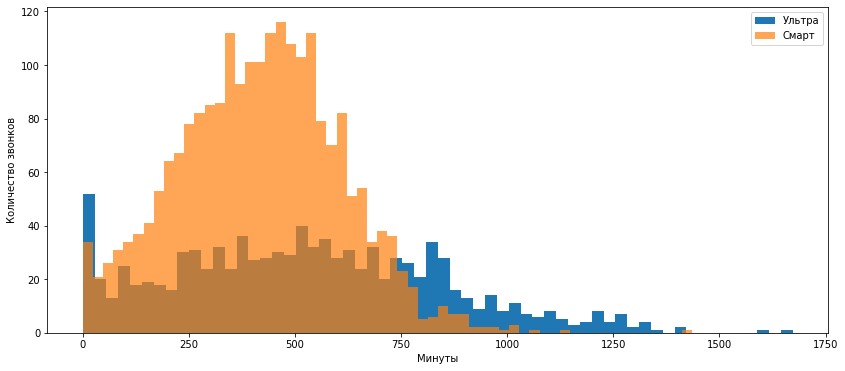

In [59]:
plt.figure(figsize=(14, 6))
plt.hist(tariff_ultra_data.minutes, bins=60, label='Ультра')
plt.hist(tariff_smart_data.minutes, bins=60, label='Смарт', alpha=0.7)
plt.xlabel('Минуты')
plt.ylabel('Количество звонков')
plt.legend()
plt.show()

В тарифе "Смарт", как в более массовом, количество звонков больше, но длительность выше в "Ультра".

Построим диаграммы размаха, чтобы посмотреть на **скошенность данных**.

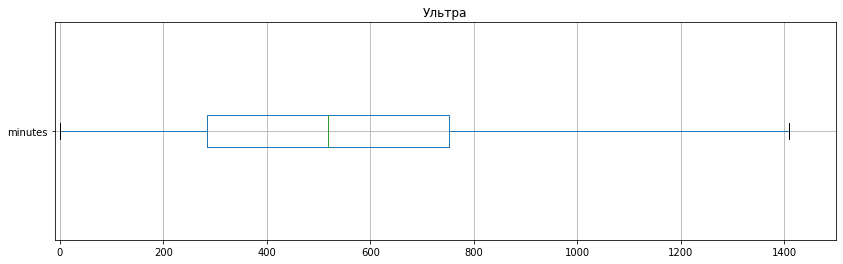

In [60]:
plt.figure(figsize=(14, 4))
tariff_ultra_data.minutes.plot(kind='box', grid=True, vert=False)
plt.xlim(-10, 1500)
plt.title('Ультра')
plt.show()

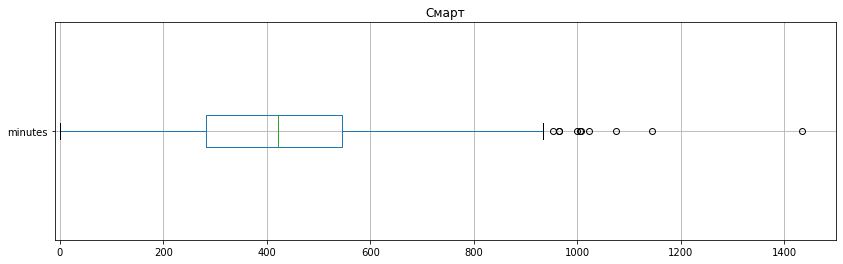

In [61]:
plt.figure(figsize=(14, 4))
tariff_smart_data.minutes.plot(kind='box', grid=True, vert=False)
plt.xlim(-10, 1500)
plt.title('Смарт')
plt.show()

Скошенность данных внутри тарифов почти не наблюдается. Абоненты достаточно стабильны в своём поведении. Однако, в тарифе "Ультра", пользователи говорят дольше. Третий квартиль заканчивается на 750 минутах, а "ус" тянется до 1400. Тогда как в "Смарте", основная масса звонков обрывается на, примерно, 550 минутах, а после 900 минут и, вовсе, начинаются выбросы.


Пользователи "Смарта" стараются **не превышать лимит**, заложенный в тарифе. Превысить лимит "Ультра", в 3000 минут, под силу не каждому.

Что же в абсолютных цифрах дохода со звонков?

In [62]:
users_data.groupby('tariff', as_index=False).calls_income.sum()

,tariff,calls_income
0,smart,278217.0
1,ultra,0.0


Любопытно, но на звонках тарифа "Ультра", оператор не зарабатывает.


Продолжаем исследование.

Изучим **сообщения**.

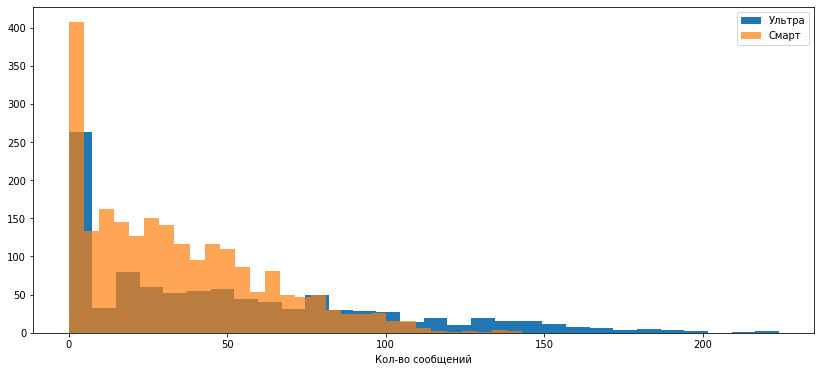

In [63]:
plt.figure(figsize=(14, 6))
plt.hist(tariff_ultra_data.messages, bins=30, label='Ультра')
plt.hist(tariff_smart_data.messages, bins=30, label='Смарт', alpha=0.7)
plt.xlabel('Кол-во сообщений')
plt.legend()
plt.show()

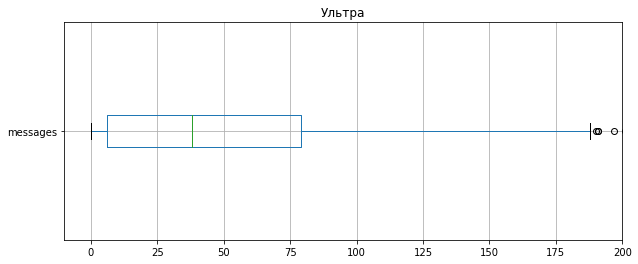

In [64]:
plt.figure(figsize=(10, 4))
tariff_ultra_data.messages.plot(kind='box', grid=True, vert=False)
plt.xlim(-10, 200)
plt.title('Ультра')
plt.show()

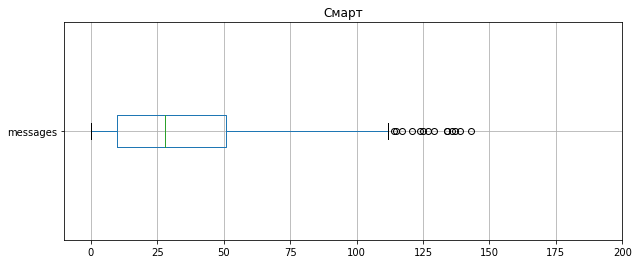

In [65]:
plt.figure(figsize=(10, 4))
tariff_smart_data.messages.plot(kind='box', grid=True, vert=False)
plt.xlim(-10, 200)
plt.title('Смарт')
plt.show()

На "Ультре" пишут больше. Когда в "Смарте" уже иссяк словарный запас, "Ультра" только разогревается. Для них 100 сообщений в месяц - не предел.


Как и в звонках, основная масса пользователей "Смарта", стараются не превышать лимит в 50 сообщений.

С кого же мы зарабатываем на сообщениях?

In [66]:
users_data.groupby('tariff', as_index=False).msg_income.sum()

,tariff,msg_income
0,smart,38784.0
1,ultra,0.0


И опять "Смарт" вне конкуренции.

На очереди - **интернет**.

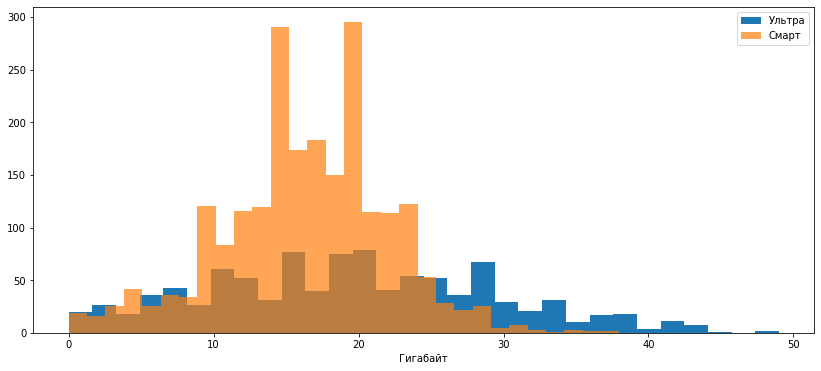

In [67]:
plt.figure(figsize=(14, 6))
plt.hist(tariff_ultra_data.gigabytes, bins=30, label='Ультра')
plt.hist(tariff_smart_data.gigabytes, bins=30, label='Смарт', alpha=0.7)
plt.xlabel('Гигабайт')
plt.legend()
plt.show()

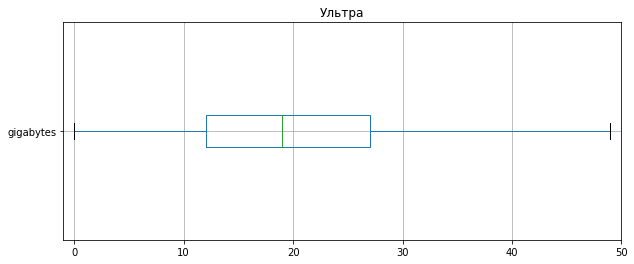

In [68]:
plt.figure(figsize=(10, 4))
tariff_ultra_data.gigabytes.plot(kind='box', grid=True, vert=False)
plt.xlim(-1, 50)
plt.title('Ультра')
plt.show()

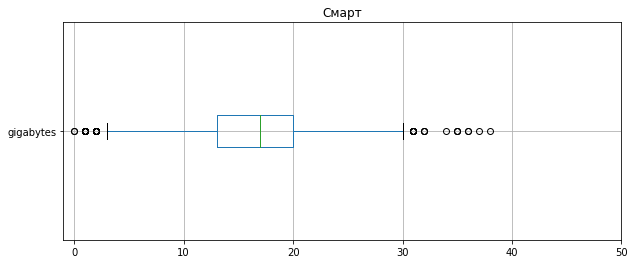

In [69]:
plt.figure(figsize=(10, 4))
tariff_smart_data.gigabytes.plot(kind='box', grid=True, vert=False)
plt.xlim(-1, 50)
plt.title('Смарт')
plt.show()

Оказывается, в тарифе "Ультра", много людей, которые вообще не пользуются интернетом. Левый "ус" совершенно спокойно упирается в нулевую отметку. Тогда как на "Смарте", значения ниже, примерно, четырёх гигабайт, являются выбросами.


В среднем, пользователи "Смарта" превышают лимит в 15 гигабайт в месяц, но берут себя в руки и останавливаются на 20. Барьер "Ультры" в 30 гигабайт берётся с трудом, но некоторые пробивают отметку и в 40.

Что по фактической прибыли с интернета?

In [70]:
users_data.groupby('tariff', as_index=False).int_income.sum()

,tariff,int_income
0,smart,1332400.0
1,ultra,118350.0


"Ультра" показал нос, но, разница более чем в один миллион, делает его попытки тщетными.

**Что же по общим цифрам прибыли с тарифов?**

In [71]:
users_data.groupby('tariff', as_index=False).total_income.sum()

,tariff,total_income
0,smart,2875351.0
1,ultra,2039100.0


При разгромном лидировании тарифа "Смарт", по всем предыдущим пунктам, абонентская плата тарифа "Ультра", не дала ему остаться совсем в аутсайдерах, и быть выброшенным на свалку истории, из списка тарифов «Мегалайна». Да, разница между тарифами почти в миллион, но и тарифом "Ультра" пользуется гораздо меньше человек. Можно пошевелить маркетологов, чтобы придумали интересные способы привлечения клиентов в "Ультра". 

А что по **средней прибыли** с каждого тарифа?

In [72]:
round(users_data.groupby('tariff', as_index=False).total_income.mean())

,tariff,total_income
0,smart,1290.0
1,ultra,2070.0


Вот где "Ультра" вышла в лидеры.

Однако, чтобы понять, различается ли средняя выручка пользователей разных тарифов, недостаточно просто сравнить значения за определённый период. Без проведения **корректного теста** нельзя считать отличия случайными или разницу достаточной, чтобы называть суммы разными.

## Проверяем гипотезы

В наших подсчётах, мы будем проверять гипотезы о равенстве средних двух генеральных совокупностей.

###  Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Для начала, сформулируем нулевую и альтернативную гипотезы:

- H₀ - средняя выручка тарифов **не различается**

- H₁ - средняя выручка тарифов **различается**

Смотрим дисперсии двух выборок по тарифам.

In [73]:
np.var(tariff_ultra_data.total_income)

141373.07325620347

In [74]:
np.var(tariff_smart_data.total_income)

669485.2209234245

Зададим **критический уровень значимости alpha - 5%**. Если p-value окажется меньше него - отвергнем нулевую гипотезу.

In [75]:
alpha = 0.05

#Поскольку, дисперсии выборок различаются, ставим параметр equal_var=False
results = st.ttest_ind(tariff_ultra_data.total_income, tariff_smart_data.total_income, equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


**P-значение** меньше критического уровня значимости. **Отвергаем нулевую гипотезу**. Средняя выручка тарифов **различается**.


Полученное значение p-value говорит нам о том, что разница в средней выручке, не случайна. На основании этого, можно сделать вывод о значимом различии между средней выручкой тарифов.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

- H₀ - средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов

- H₁ - средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

Для начала, посмотрим на фактическую выручку по городам.

In [76]:
city_total_income = round(users_data.groupby('city', as_index=False).agg({'total_income': 'sum'}).\
sort_values(by='total_income', ascending=False))
city_total_income.head()

,city,total_income
31,Москва,945042.0
50,Санкт-Петербург,436982.0
39,Новосибирск,174542.0
67,Уфа,145762.0
24,Краснодар,132790.0


Москва в лидерах. Не удивительно.

Сделаем выборки по Москве и другим городам.

In [77]:
moscow_city = users_data.loc[users_data['city'] == 'Москва']
other_cities = users_data.loc[users_data['city'] != 'Москва']

Подсчитаем дисперсию по выборкам.

In [78]:
np.var(moscow_city.total_income)

564710.7117467273

In [79]:
np.var(other_cities.total_income)

653886.3270894174

Зададим **критический уровень значимости alpha - 5%**. Если p-value окажется меньше него - отвергнем нулевую гипотезу.

In [80]:
alpha=0.05

#Поскольку, дисперсии выборок различаются, ставим параметр equal_var=False
results = st.ttest_ind(moscow_city.total_income, other_cities.total_income, equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


**Отвергнуть нулевую гипотезу не получилось**. Средняя выручка пользователей из Москвы, **не отличается** от средней выручки пользователей из других регионов.

## Вывод

Компания «Мегалайн», федеральный оператор сотовой связи, предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Коммерческий департамент хочет понять, какой тариф приносит больше денег. 

Мы проанализировали поведение клиентов внутри тарифа и пришли к выводам:

- тариф "Смарт" имеет более широкий охват аудитории

- в среднем, пользователи тарифа "Ультра", тратят больше минут звонков в месяц, отсылают больше сообщений и тратят больше гигабайт интернет-трафика, однако не выходят за рамки тарифного лимита и не платят за дополнительные минуты и гигабайты.

- пользователи тарифа "Смарт", в среднем, так же неохотно преодолевают тарифные лимиты. Исключение составляет интернет-трафик, лимит которого преодолевается гораздо чаще.

- несмотря на околонулевую прибыль от преодоления пользователями лимитного барьера, тариф "Ультра" покрывает всё абонентской платой.


Чтобы понять, является ли разность в выручке из разных тарифов статистически значимой, мы провели статистические тесты и выяснили:

- средняя выручка разных тарифов, отличатеся не только фактически, но и статистически значимо.

- средняя выручка пользователей из Москвы, не отличается от средней выручки пользователей из других регионов.


Подытожив, можно сказать, что оба тарифа приносят компании, в среднем, разную прибыль. 

Пользователи тарифа "Ультра", хоть и в меньшинстве, но более активные, совершают больше звонков, тратят больше интернет-трафика. Они готовы считаться с высокой абонентской платой, чтобы не ограничивать себя.

- по нашим данным, общая выручка с тарифа, за выбранный период, составила 2 039 100 рублей.

- средняя выручка на пользователя составляет 2 070 рублей.

Тариф "Смарт" рассчитан на массовость и покрывает более широкую аудиторию. Также, низкий тарифный лимит, способствует более частому его преодолению и, как следствие, необходимость оплаты услуг сверх тарифного пакета.

- общая выручка с тарифа, за выбранный период, составила 2 875 351 рубль.

- средняя выручка на пользователя 1 290 рублей.

Отвечая на вопрос коммерческого департамента «Мегалайн» - тариф "Смарт" приносит больше денег. В него стоит направить рекламный бюджет. 